In [108]:
%pylab inline

import scipy.stats as stat
import sklearn.linear_model as lm
import scipy.optimize as opt
import pandas as pd
from scipy.ndimage.interpolation import shift

rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [12]:
import pandas_datareader.data as web
df = web.DataReader('TSLA', 'stooq').Close.iloc[::-1]

In [72]:
LnR = np.log(df/df.shift(1))
LnR_normed = (LnR - LnR.mean()).iloc[1:]
vol = np.sqrt((LnR_normed**2).mean())

In [262]:
cdfx = np.linspace(LnR_normed.min(),LnR_normed.max(),100)
f_cdf = np.vectorize(lambda x: len(LnR_normed[LnR_normed < x])/len(LnR_normed))
cdfy = f_cdf(cdfx)
cdf_inv = np.vectorize(lambda p: cdfx[len(cdfy[cdfy<=p])-1])
cdf_inv_mu = -0.0027735211472719743
cdf_inv_normed = lambda p: cdf_inv(p)-cdf_inv_mu

In [308]:
cdfx2 = np.linspace(LnR_normed.min(),LnR_normed.max(),5000)
cdfy2 = f_cdf(cdfx2)
cdfy2_interp = np.interp(cdfx2,cdfx,cdfy)
cdf_inv2 = np.vectorize(lambda p: cdfx2[len(cdfy2_interp[cdfy2_interp<=p])-1])

In [326]:
norm_equiv = stat.norm.cdf(cdfx,loc=0,scale=vol)
norm_equiv2 = stat.norm.cdf(cdfx2,loc=0,scale=vol)

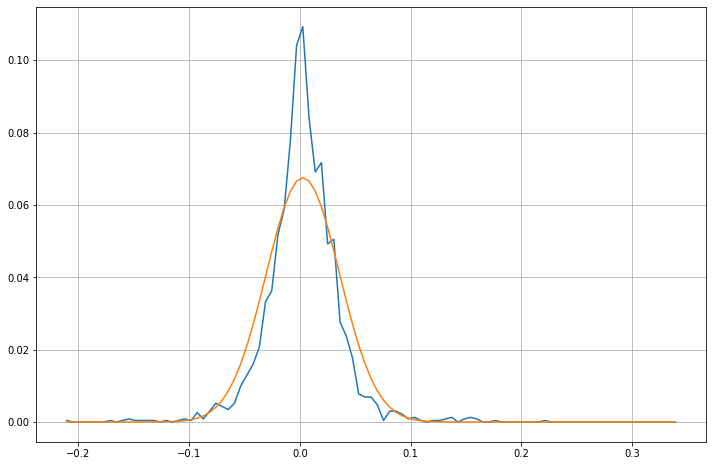

In [318]:
plot(cdfx[1:],np.diff(cdfy))
plot(cdfx[1:],np.diff(norm_equiv))

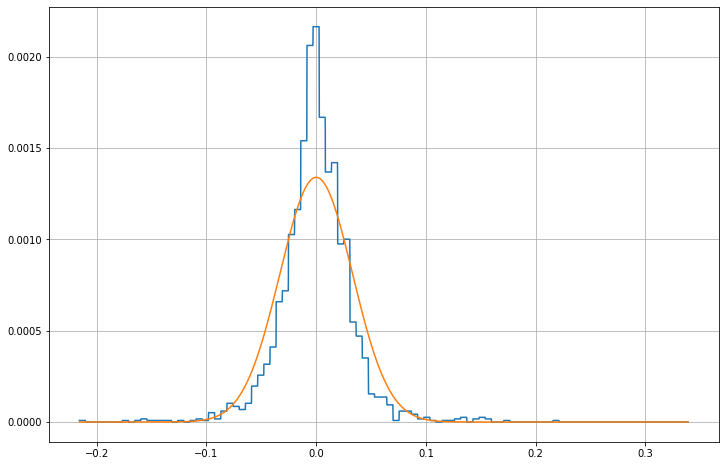

In [332]:
plot(cdfx2[1:],np.diff(cdfy2_interp))
plot(cdfx2[1:],np.diff(norm_equiv2))

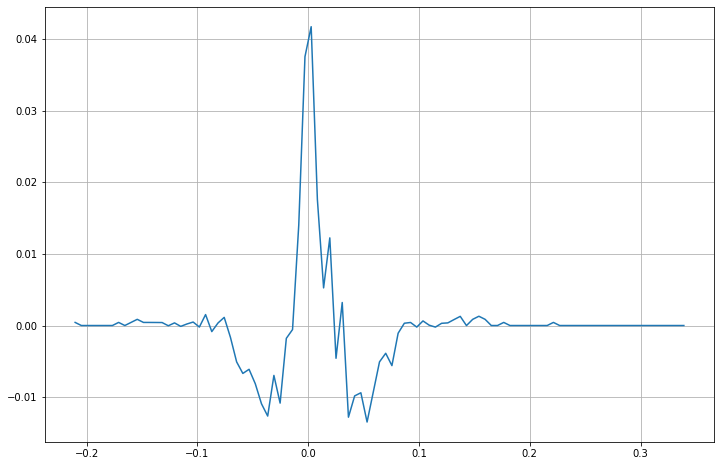

In [247]:
plot(cdfx[1:],np.diff(cdfy)-np.diff(norm_equiv))

In [339]:
solver = np.vectorize(lambda i: opt.brentq(lambda v: cdfy[i]-stat.norm.cdf(cdfx[i],scale=v),0.0001,100.0))

In [340]:
solved_vols = solver(np.arange(len(cdfy)))

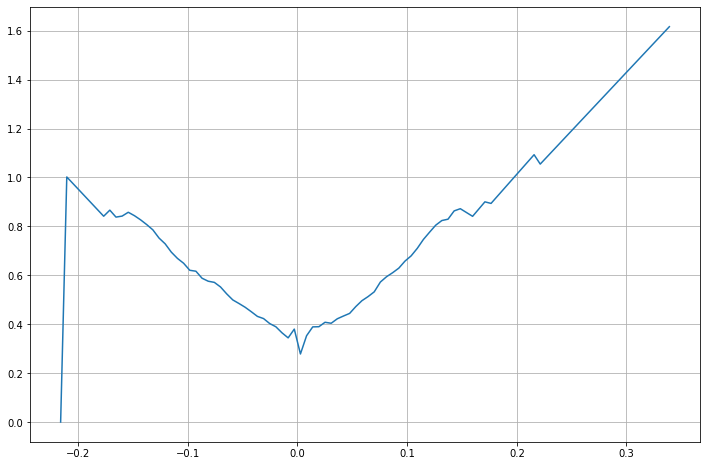

In [342]:
plot(cdfx,solved_vols*np.sqrt(252))

In [310]:
def CDFgen(num_paths,num_steps):
    rands = np.random.uniform(size=(num_paths,num_steps))
    return (1+cdf_inv2(rands)).cumprod(axis=1)

In [309]:
rands = np.random.uniform(size=(1000000,1))
vals = cdf_inv2(rands)
vals.mean()

-3.14713988353813e-05

In [333]:
paths = CDFgen(100000,252)

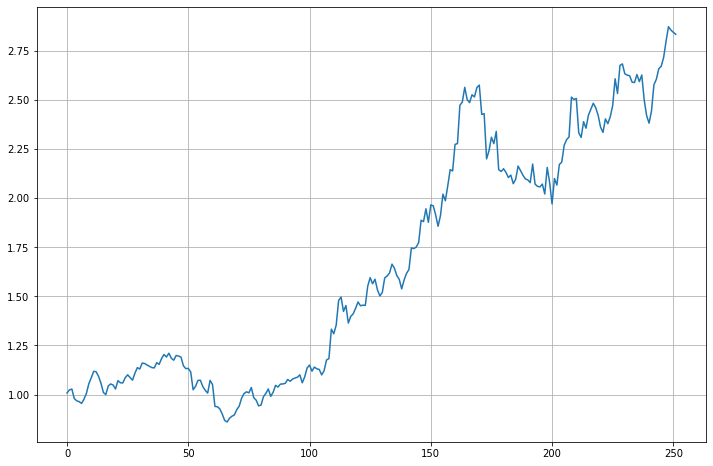

In [321]:
plot(paths[0])

In [334]:
paths[:,-1].mean()

0.9898582724615826

In [268]:
sim_vol = np.sqrt((np.log(paths[:,1:]/paths[:,:-1])**2).mean())
sim_vol*np.sqrt(252)

0.523831436416669

In [120]:
def GBM(sigma,num_paths,num_steps):
    return (1+sigma*np.random.normal(size=(num_paths,num_steps))).cumprod(axis=1)

In [203]:
gbmpaths = GBM(sim_vol,100000,252)

In [277]:
gbmpaths[:,-1].mean()

1.0013717372027569

In [135]:
vanilla_call = np.vectorize(lambda S_T: max(S_T-1.0,0))

In [269]:
vanilla_call(gbmpaths[:,-1]).mean()

0.20801957100869573

In [335]:
vanilla_call(paths[:,-1]).mean()

0.06459

In [324]:
vanilla_call(gbmpaths[:,-1]).max()

8.256217512653421

In [325]:
vanilla_call(paths[:,-1]).max()

4.460883233311455

In [354]:
xop = web.DataReader('XOP', 'stooq').Close[::-1]
uso = web.DataReader('USO', 'stooq').Close[::-1]

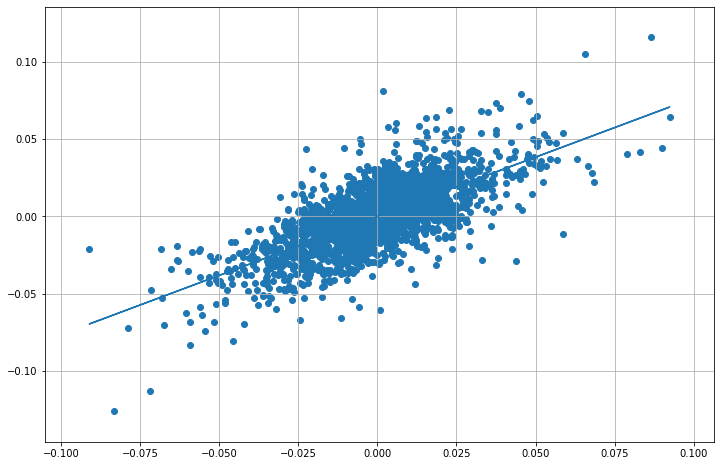

In [364]:
scatter(uso.pct_change(),xop.pct_change())
plot(uso.pct_change(),uso.pct_change()*reg.coef_)

In [361]:
reg = lm.LinearRegression().fit(uso.pct_change().values.reshape(-1,1)[1:], xop.pct_change().values[1:])

In [362]:
reg.coef_

array([0.76527077])